# Introduction

(Abstract RWA decentralized exchange)

Minimize price impact with with risk capital.

Include empirical data.  Similart


This report demonstrates the operations of the AXC backtesting framework for its
liquidity provision framework.  


In these calculations we assume a user pool of 10000 USDT and then 
we see the impact of adding a large reserve pool of 200000 USDT and of an arbitrage bot.

The code for these runs are BSD-licensed and are available at https://github.com/accelerate-protocol/axc-backtesting .  The version of
uniswappy used for these runs are located at https://github.com/hkphysics/uniswappy and contain fixes to the stock version of uniswappy.



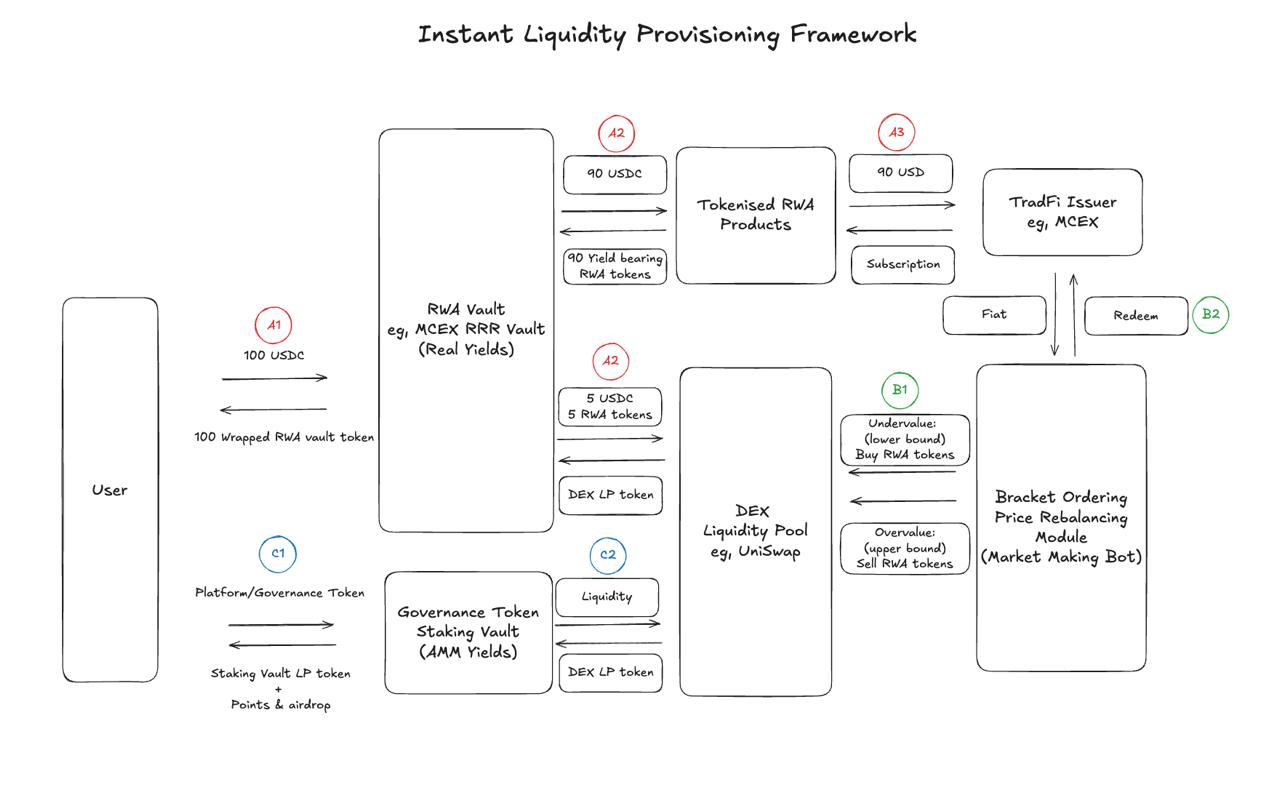


# Price impact with reserve

This calculation illustrates the impact of a large trades against uniswap with and without the reserve pool.  Without liquidity pool price will drop.

In [1]:
from uniswappy import *
from axc_lp import *

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
init_price = UniV3Utils.encodePriceSqrt(1000,1000)

usdt_in = 10**6
tenv = TokenScenario(
    user = 'user',
    user_lp = 10000,
    reserve = usdt_in * 0.2,
    name0 = "TKN",
    name1 = "USDT",
    address0 = "0x111",
    address1 = "0x09",   
    usdt_in = usdt_in,
    tick_spacing = tick_spacing,
    fee = fee,
    init_price = init_price,
    nav=1.0,
    reserve_lower = 0.9,
    seed  = 42
)


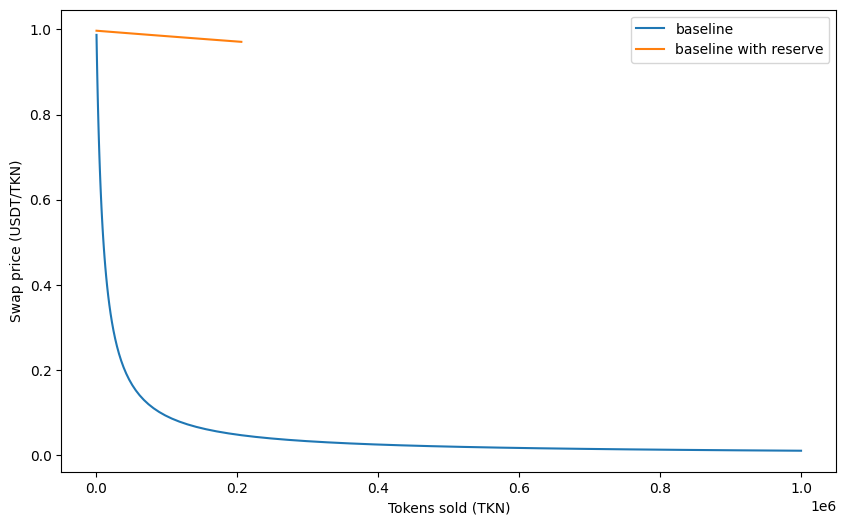

In [2]:
results = do_calc2(tenv, [[
        [tenv.user_lp, "min_tick", "max_tick"]
    ], [
        [tenv.user_lp, "min_tick", "max_tick"],
        [tenv.reserve, tenv.reserve_lower, tenv.nav]
    ]], ['baseline', 'baseline with reserve']
)
plotme(results, "", )

# Monte carlo simulation of reserve pool and market maker arbitrage bot

To demonstrate the functionality of the reserve pool and market maker arbitrage bot
four scenarios were run with runs of 500 trades and 50 paths per scenario.  The NAV
of was set at NAV.


In [3]:
from uniswappy import *
import pandas as pd
import numpy as np
from icecream import ic
import traceback
from axc_lp import *
from tqdm.autonotebook import tqdm


import numpy as np
import random
from axc_algobot import * 

params = [
    [
            [tenv.user_lp, "min_tick", "max_tick"]
    ], [
            [tenv.user_lp, "min_tick", "max_tick"],
        [tenv.reserve, tenv.reserve_lower, tenv.nav]
    ], [
            [tenv.user_lp, "min_tick", "max_tick"]
    ], [
        [tenv.user_lp, "min_tick", "max_tick"],
        [tenv.reserve, tenv.reserve_lower, tenv.nav] 
    ]
]

bots = [
    NullAlgoBot,
    NullAlgoBot,
    AlgoBot,
    AlgoBot
]

random.seed(42)
lp_price_samples = []
lp_liquidity_samples = []
adapter_log = []
for (param, bot) in tqdm(zip(params, bots), total=len(params)):
    (lp_price_sample, lp_liquidity_sample, adapter_logs) = do_paths(
        tenv, 50, 500, param, bot
    )
    lp_price_samples.append(lp_price_sample)
    lp_liquidity_samples.append(lp_liquidity_sample)
    adapter_logs.append(adapter_log)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

This plot illustrates one path in the monte carlo simulation

<Figure size 1000x500 with 0 Axes>

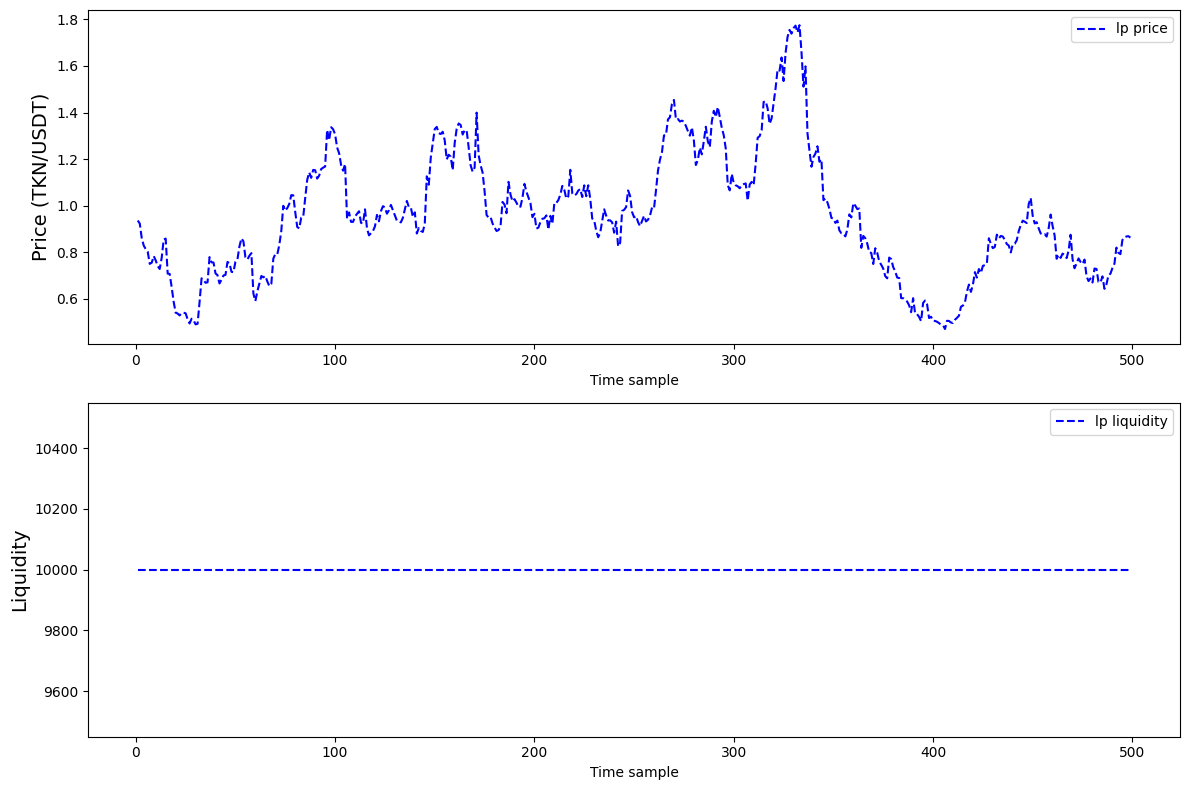

In [4]:
import matplotlib.pyplot as plt
plot_path(lp_price_samples[0][0], lp_liquidity_samples[0][0])

**Scenario 1** (Baseline scenario)
  - UniSwap no limit liquidity similar to V2
  - Total liquidity from the users is 10,000 USDT 
  - Average: 1,000 USDT per trade 



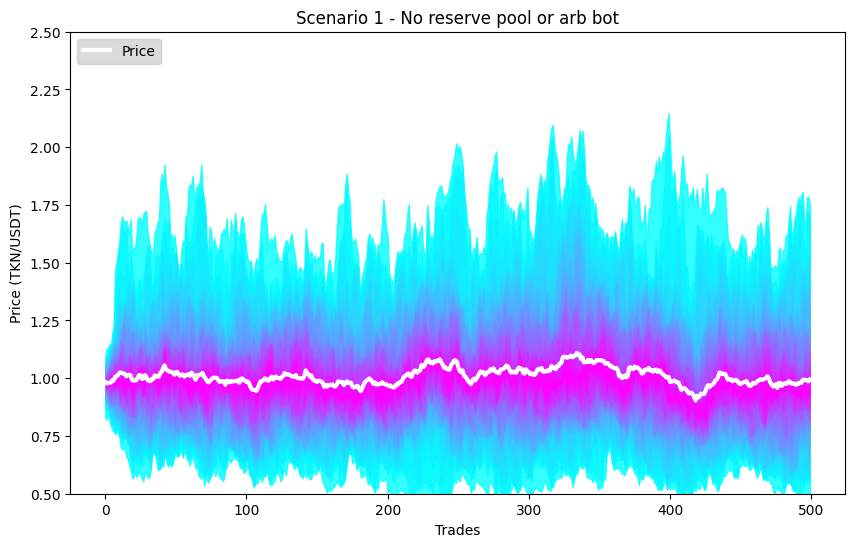

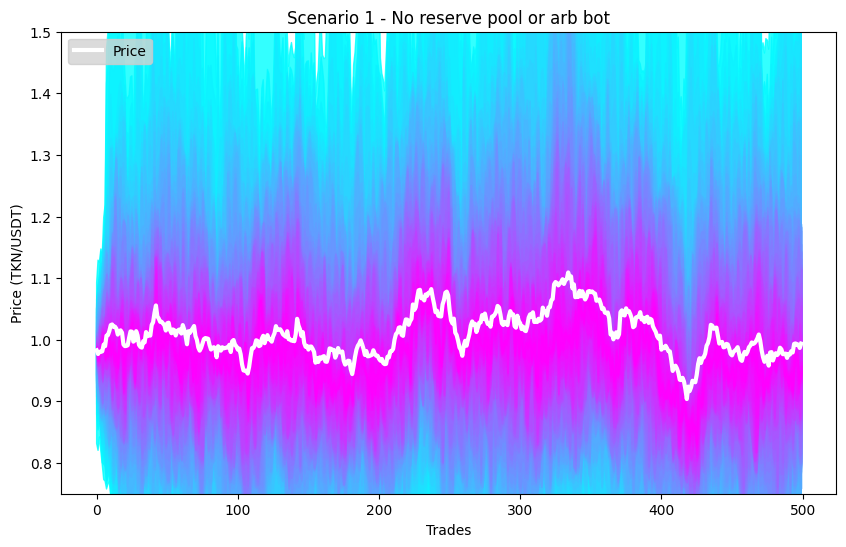

In [5]:
plot_distribution(lp_price_samples[0], "Scenario 1 - No reserve pool or arb bot", ylim=[0.5,2.5])
plot_distribution(lp_price_samples[0], "Scenario 1 - No reserve pool or arb bot")


This plot illustrates the price variation with the baseline liquidity pools

**Scenario 2** (Baseline + Reserve pool)
  - Reserve Pool: 200,000 USDT
  - From C2 and A2. From the reserve liquidity + Governance Staking Vault 

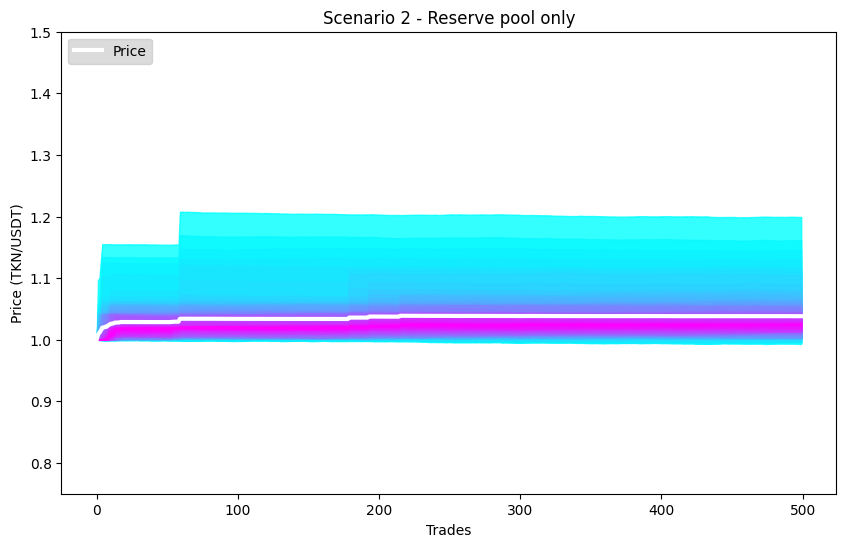

In [6]:
plot_distribution(lp_price_samples[1], "Scenario 2 - Reserve pool only")

This includes the impact of the reserve pool.  The reserve pool sets the NAV as a lower bound.

**Scenario 3** (Baseline + Arbitrage bot)
   - Bot: 10,000 RWA Token, 10,000 Cash.
   - Bot intervenes when it is above or below the NAV when to touches 5% and it will push it back to 2%. 
   - The upper and lower will be optimize but this is dependent on the order flow 
   - Whenever the cash goes below 5,000 then the bot ask for redemption (Convert: RWA token to Securities to Cash)
   - The time delay to concert from RWA token to Cash is 50 trades 


Scenario 3 includes the impact of the arb bot.  The bot by itself reduces the variation of the price.

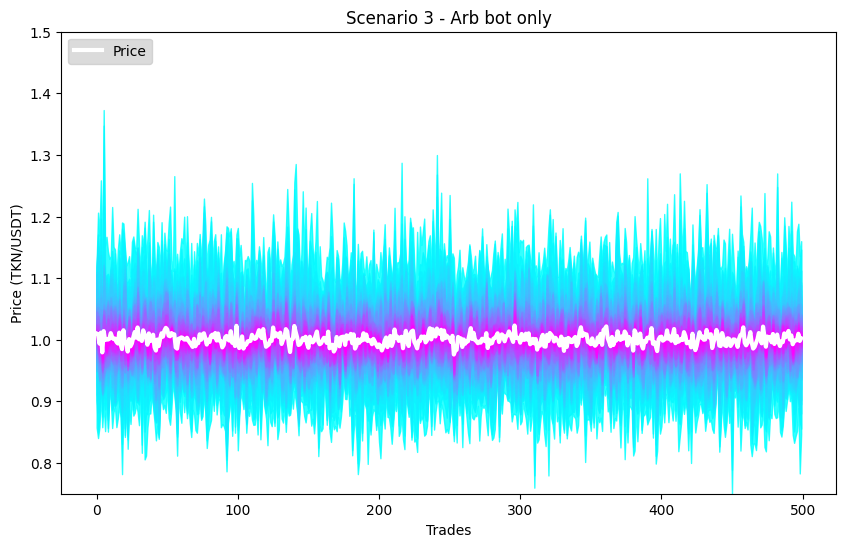

In [7]:
plot_distribution(lp_price_samples[2], "Scenario 3 - Arb bot only")

**Scenario 4** (Baseline + Reserve pool + Arbitrage bot)

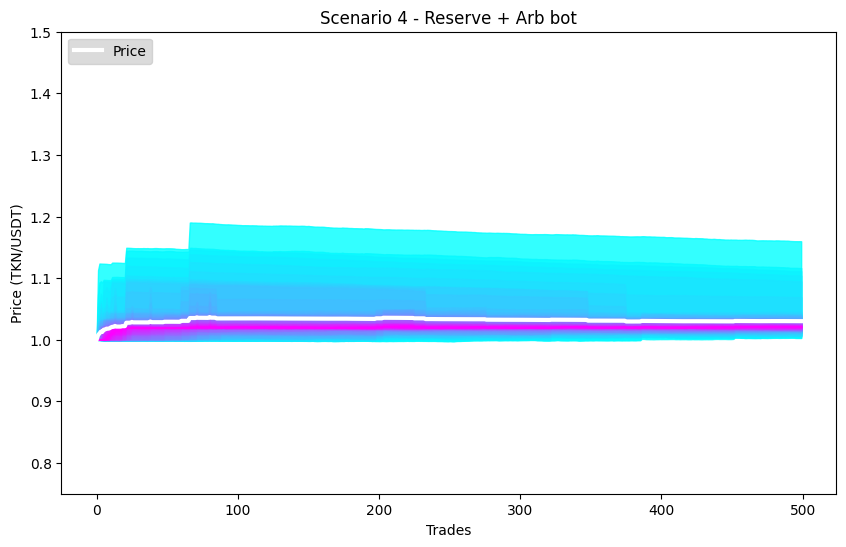

In [8]:
plot_distribution(lp_price_samples[3], "Scenario 4 - Reserve + Arb bot")

With both the bot and the reserve pool you see pool place a lower bound and also reduces the variation.